# Exercises - GEO4902-03 - Ensemble Prediction

Kjersti Stangeland, Fall 2024

# Exercise 03-02 - Ensemble prediction of a polar low

In [2]:
# import packages
import xarray as xr
import math
import numpy as np
import cartopy as cy
from matplotlib import pyplot as plt
from cmcrameri import cm

The script gives you a framework to assess ensemble forecasts from the Scandinavian ensemble forecasting system. All 10 ensemble members are within one forecast file.
The polar low occurred on 4th February 2020 at about 2 pm, as described in exercise 01.

__Task 1:__
- Plot the wind speed forecasts at Tromsø for all ensemble members.

In [3]:
year =  '2020'
day  =  '03'
month = '02'
hour_1  ='18'

url='https://thredds.met.no/thredds/dodsC/meps25epsarchive/' +year+'/'+month+'/'+day+'/meps_extracted_2_5km_'+year+month+day+'T'+hour_1+'Z.nc'
forecast_1 = xr.open_dataset(url)

### Find a specific point and plot the forecast. 


In [4]:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslat,abslon)
    
    y, x = np.where(c == np.min(c))

    y=int(y)
    x=int(x)
   
    return (y,x)

In [18]:
[y_loc, x_loc] = findindex(forecast_1.latitude,forecast_1.longitude,69.649,18.956) # Tromsø

#print("Tromsø_forecast 1: latitude: {}; longitude: {}".format(forecast_1.latitude.isel(y=y_loc,x=x_loc).round(2), forecast_1.longitude.isel(y=y_loc,x=x_loc).round(2)))

/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_14683/2975422917.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y=int(y)
/var/folders/tp/bn0hk5sx7fq7r171hlv9tzq40000gn/T/ipykernel_14683/2975422917.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x=int(x)


Text(0.5, 1.0, 'Wind speed forecast for Tromsø')

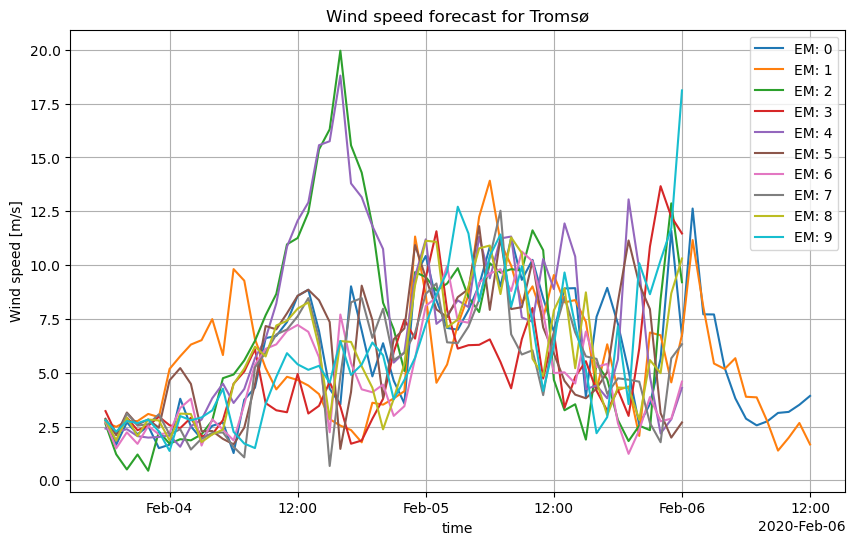

In [16]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(0, 10):
    forecast_1.wind_speed.isel(height3=0, ensemble_member=i, y=y_loc, x=x_loc).plot(ax=ax, label=f'EM: {i}')

ax.legend()
ax.grid()
ax.set_ylabel('Wind speed [m/s]')

plt.title('Wind speed forecast for Tromsø')

__Comments on task 1:__

'What would be a good way to define a forecast product dependent on the lead time?'

-  I'm not sure if I understand the question correctly.. Lead time is the 'length' of a forecast, and from the compendium we see that the relative error of the ensemble mean increases with increasing lead time. Hence is the ensemble mean and spread dependent on the lead time. 

__Task 2:__
- Plot the spread (as we defined it in the course) for the ensemble wind forecast.

In [17]:
wind_speed = forecast_1.wind_speed
ensemble_mean = wind_speed.mean(dim='ensemble_member')

In [19]:
ensemble_var = wind_speed.var(dim='ensemble_member')

In [20]:
spread = ensemble_var.mean(dim='time')

Text(0.5, 1.0, 'Wind speed Tromsø')

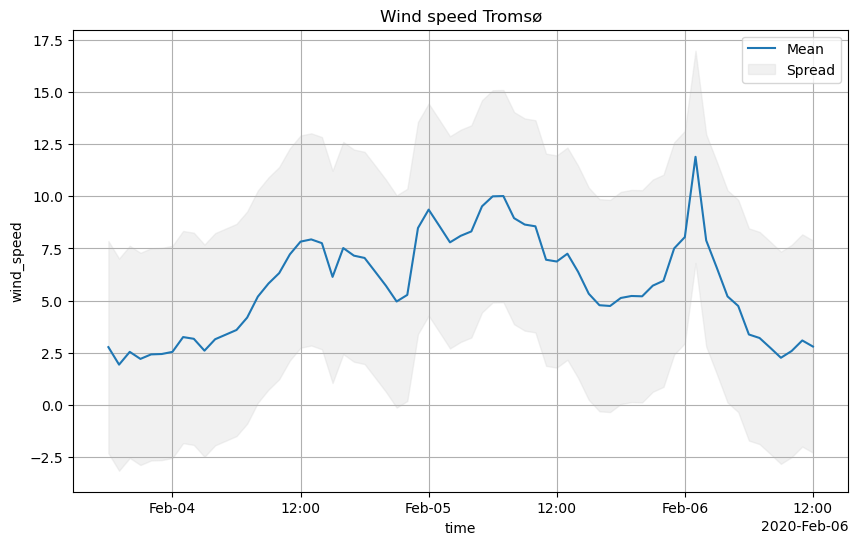

In [29]:
fig, ax = plt.subplots(figsize=(10,6))
ensemble_mean.isel(height3=0, x= x_loc, y=y_loc).plot(ax=ax, label='Mean')

mean = ensemble_mean.isel(height3=0, x= x_loc, y=y_loc)
spreadd = spread.isel(height3=0, x=x_loc, y=y_loc)
ax.fill_between(ensemble_mean.time, mean - spreadd, mean + spreadd, color="lightgrey", alpha=0.3, label="Spread")

ax.legend()
ax.grid()

plt.title('Wind speed Tromsø')

__Comments on task 2:__
- The spread, defined in the lecture notes and compendium, is the square root of the mean of the variance.
-> If its the mean of the variances wrt time -> a spatial map makes sense
-> If its the mean of the variance wrt ensemble members (does this make sense?) -> a timeseries plot of the spread makes sense

__Task 3:__
- Plot the sea level pressure map for different ensemble members. What could here be a good way of showing the position of the polar low by using the forecast information of the 10 ensemble members?

#### For example wind speed forecasts

In [5]:
member=1
accpp_point_forecast_1 = forecast_1['wind_speed'].isel(height3=0, ensemble_member=0, y=y_loc, x=x_loc)
accpp_point_forecast_1 = accpp_point_forecast_1.assign_attrs({'long_name': 'Wind speed'}) #rename attribute of long name as it should be wind speed and not direction

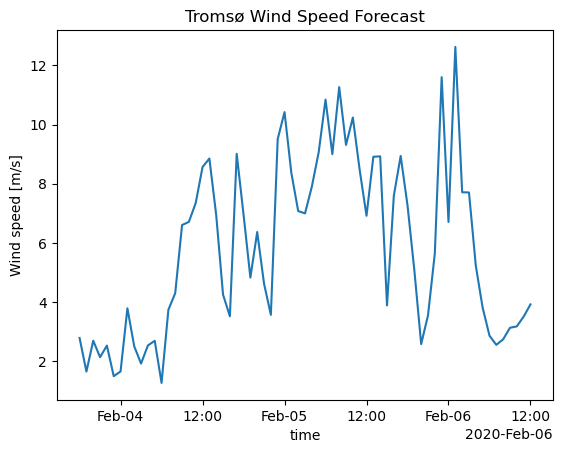

In [6]:
f, ax = plt.subplots()                              # define figure

accpp_point_forecast_1.plot.line(ax = ax, x='time', add_legend=True)                             # plot with xarray.plot function
plt.title("Tromsø Wind Speed Forecast");

### Plot forecast on a map
Mean sea level pressure

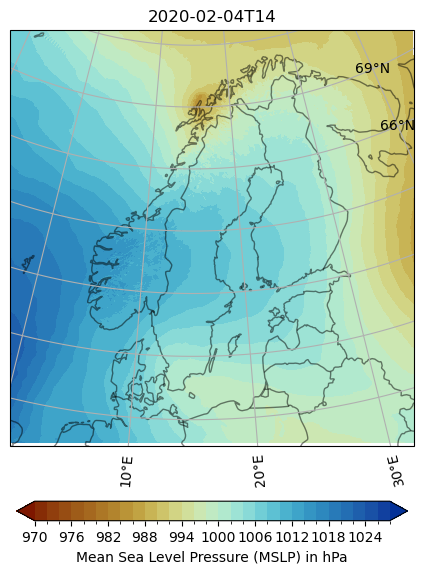

In [7]:
timestep = 20
mlevel = 0
member = 7

projection = cy.crs.Stereographic(central_latitude=75, central_longitude=15.0, )
f, axsm = plt.subplots(1,1, subplot_kw={'projection':projection}, figsize=[7.2, 7.2])

# plot cosmetics
axsm.set_extent([1, 32, 52, 72], cy.crs.PlateCarree())
axsm.add_feature(cy.feature.COASTLINE, alpha=0.5)
axsm.add_feature(cy.feature.BORDERS, alpha=0.5)
gl = axsm.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=True

(forecast_1['air_pressure_at_sea_level'].isel(time=timestep, height_above_msl=mlevel, ensemble_member=member)/100).plot.pcolormesh(ax=axsm, 
                                                                                                                   x='longitude', 
                                                                                                                   y='latitude',
                                                                                                                   cmap=cm.roma,
                                                                                                                   extend='both',
                                                                                                                   levels=np.arange(970,1030, 2),
                                                                                                                   transform=cy.crs.PlateCarree(),
                                                                                                                   cbar_kwargs={'orientation':'horizontal','label':'{} in hPa'.format(forecast_1['air_pressure_at_sea_level'].attrs['long_name'],), 'shrink':0.7, 'pad':0.1})


plt.title (np.datetime_as_string(forecast_1.time[timestep],unit='h'));